In [1]:
import pandas as pd
import os
import json
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import matplotlib as mpl
from matplotlib.pyplot import cm

In [3]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [4]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

## Get GTEx significant associations

In [5]:
sig_eqtl="/cellar/users/mpagadal/Data/gtex/GTEx_Analysis_v8_eQTL_EUR"
files=[x for x in os.listdir(sig_eqtl) if "pairs" in x]

In [6]:
mapping=pd.read_csv("/cellar/users/mpagadal/Data/gtex/GTEx_Analysis_2017-06-05_v8_WholeGenomeSeq_838Indiv_Analysis_Freeze.lookup_table.txt",delimiter="\t")
mp_b38_b37=dict(zip(mapping.variant_id,mapping.variant_id_b37))

In [7]:
#get snp lst
snps=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/immune-microenvironment-nonhla.tsv",delimiter="\t")
snps["assoc"]=snps["snps"]+"_"+snps["file"]
snp_lst=snps["snps"].tolist()+[x.rsplit(":",2)[0]+":"+x.split(":")[3]+":"+x.split(":")[2] for x in snps["snps"].tolist()]


In [7]:
compiled_cis=pd.DataFrame()

for x in files:
    eqtl=pd.read_csv(sig_eqtl+"/"+x,delimiter="\t")
    eqtl["variant_b37"] = eqtl["variant_id"].map(mp_b38_b37)
    eqtl["variant"] = eqtl["variant_b37"].str.split("_").str[0]+":"+eqtl["variant_b37"].str.split("_").str[1]+":"+eqtl["variant_b37"].str.split("_").str[2]+":"+eqtl["variant_b37"].str.split("_").str[3]
    eqtl["cell"]=x.split(".v8")[0]
    eqtl_filt=eqtl[eqtl["variant"].isin(snp_lst)]
    compiled_cis=compiled_cis.append(eqtl_filt)

In [8]:
compiled_cis["gene_id"]=compiled_cis["phenotype_id"].str.split(".").str[0]

In [9]:
with open('/cellar/users/mpagadal/Data/resources/tcga/ensembl_map.json', 'r') as f:
    ensembl_dict = json.load(f)

In [10]:
ensembl_dict={k.split(".")[0]:v for k,v in ensembl_dict.items()}

In [11]:
compiled_cis["gtex gene"]=compiled_cis["gene_id"].map(ensembl_dict)

In [12]:
compiled_cis=compiled_cis.rename(columns={"variant":"snps"})

In [13]:
compiled_cis["assoc"]=compiled_cis["snps"]+"_"+compiled_cis["gtex gene"]

## combine gtex and tcga data frame

In [14]:
gtex_assoc=pd.merge(snps,compiled_cis[["snps","gtex gene","cell","gene_id"]],on="snps",how="left")

In [15]:
cis=gtex_assoc[~(gtex_assoc["cis tss"].isnull())]["assoc"].unique()
trans=gtex_assoc[gtex_assoc["cis tss"].isnull()]["assoc"].unique()

In [16]:
len(cis)

389

In [17]:
len(trans)

93

In [18]:
gtex_cis=gtex_assoc[gtex_assoc["assoc"].isin(cis)]
gtex_cis=gtex_cis[gtex_cis["gtex gene"]==gtex_cis["file"]]["assoc"].unique().tolist()

In [19]:
len(gtex_cis)

171

In [20]:
gtex_trans=gtex_assoc[gtex_assoc["assoc"].isin(trans)]
gtex_trans=gtex_trans[~(gtex_trans["gtex gene"].isnull())]["assoc"].unique().tolist()

In [21]:
len(gtex_trans)

42

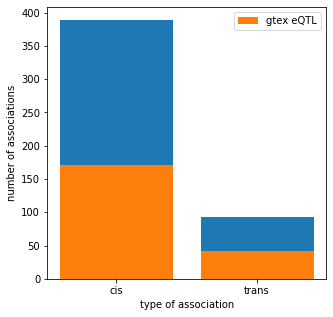

In [22]:
f=plt.figure(figsize=(5,5))
plt.bar(["cis","trans"],[len(cis),len(trans)])
plt.bar(["cis","trans"],[len(gtex_cis),len(gtex_trans)],label="gtex eQTL")
plt.ylabel("number of associations")
plt.xlabel("type of association")
plt.legend()
plt.savefig("gtex.eqtl.pdf")

In [27]:
len(trans)

93

In [28]:
combos=['Kidney_Cortex.KICH',
 'Kidney_Cortex.KIRC',
 'Kidney_Cortex.KIRP',
 'Testis.TGCT',
 'Brain_Hippocampus.GBM',
 'Skin_Sun_Exposed_Lower_leg.SKCM',
 'Ovary.OV',
 'Colon_Transverse.COAD',
 'Adrenal_Gland.ACC',
 'Pancreas.PAAD',
 'Esophagus_Muscularis.ESCA',
 'Stomach.STAD',
 'Thyroid.THCA',
 'Breast_Mammary_Tissue.BRCA',
 'Minor_Salivary_Gland.HNSC',
 'Brain_Anterior_cingulate_cortex_BA24.LGG',
 'Liver.LIHC',
 'Prostate.PRAD',
 'Uterus.UCEC',
 'Lung.LUAD',
 'Lung.LUSC']
gtex_tissues=[x.split(".")[0] for x in combos]

In [35]:
overlap=compiled_cis[compiled_cis["cell"].isin(gtex_tissues+["Whole_Blood"])]

In [36]:
overlap[overlap["cell"]=="Ovary"]

,phenotype_id,variant_id,tss_distance,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,pval_nominal_threshold,min_pval_nominal,pval_beta,variant_b37,snps,cell,gene_id,gtex gene,assoc
12951,ENSG00000137944.17,chr1_88970498_T_C_b38,-17857,0.492754,105,136,5.149730e-16,-0.685658,0.072510,0.000040,5.149730e-16,1.320690e-12,1_89436181_T_C_b37,1:89436181:T:C,Ovary,ENSG00000137944,CCBL2,1:89436181:T:C_CCBL2
12977,ENSG00000117226.11,chr1_89007941_G_A_b38,-14953,0.217391,54,60,2.270330e-14,-0.849128,0.097089,0.000035,1.970530e-23,5.584150e-20,1_89473624_G_A_b37,1:89473624:G:A,Ovary,ENSG00000117226,GBP3,1:89473624:G:A_GBP3
13215,ENSG00000213512.1,chr1_89013185_G_A_b38,-162855,0.213768,51,59,1.097480e-07,0.690733,0.121836,0.000037,2.009080e-23,6.199130e-20,1_89478868_G_A_b37,1:89478868:G:A,Ovary,ENSG00000213512,GBP7,1:89478868:G:A_GBP7
13581,ENSG00000213512.1,chr1_89269631_G_A_b38,93591,0.159420,39,44,2.537890e-07,0.730051,0.133134,0.000037,2.009080e-23,6.199130e-20,1_89735314_G_A_b37,1:89735314:G:A,Ovary,ENSG00000213512,GBP7,1:89735314:G:A_GBP7
20685,ENSG00000163131.10,chr1_150662590_C_T_b38,-103367,0.373188,84,103,1.111700e-05,0.250100,0.054395,0.000053,2.878820e-06,1.898220e-03,1_150635066_C_T_b37,1:150635066:C:T,Ovary,ENSG00000163131,CTSS,1:150635066:C:T_CTSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267972,ENSG00000172543.7,chr11_65877883_A_G_b38,-1926,0.235507,54,65,2.438390e-07,0.565823,0.103017,0.000059,2.438390e-07,2.249600e-04,11_65645354_A_G_b37,11:65645354:A:G,Ovary,ENSG00000172543,CTSW,11:65645354:A:G_CTSW
267974,ENSG00000172543.7,chr11_65879086_C_A_b38,-723,0.235507,54,65,2.438390e-07,0.565823,0.103017,0.000059,2.438390e-07,2.249600e-04,11_65646557_C_A_b37,11:65646557:C:A,Ovary,ENSG00000172543,CTSW,11:65646557:C:A_CTSW
268171,ENSG00000254461.1,chr11_65793898_G_A_b38,-465944,0.188406,43,52,2.534050e-05,-0.317499,0.072302,0.000063,1.253940e-05,8.323480e-03,11_65561369_G_A_b37,11:65561369:G:A,Ovary,ENSG00000254461,RP11-755F10.3,11:65561369:G:A_RP11-755F10.3
291881,ENSG00000127337.6,chr12_69338325_T_C_b38,-21378,0.438406,94,121,1.200480e-10,-0.488782,0.068943,0.000033,2.780670e-11,1.211150e-07,12_69732105_T_C_b37,12:69732105:T:C,Ovary,ENSG00000127337,YEATS4,12:69732105:T:C_YEATS4


Kidney_Cortex
Kidney_Cortex
Kidney_Cortex
Testis
Brain_Hippocampus
Skin_Sun_Exposed_Lower_leg
Ovary
Colon_Transverse
Adrenal_Gland
Pancreas
Esophagus_Muscularis
Stomach
Thyroid
Breast_Mammary_Tissue
Minor_Salivary_Gland
Brain_Anterior_cingulate_cortex_BA24
Liver
Prostate
Uterus
Lung
Lung


/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  fig.canvas.print_figure(bytes_io, **kw)


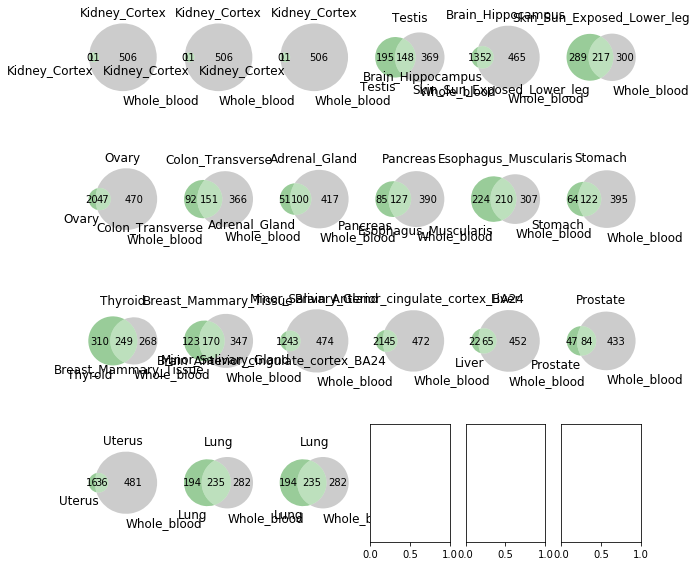

In [43]:
fig, axs = plt.subplots(4, 6, sharey=True, tight_layout=True, figsize=(10, 10))
axli = axs.flatten()

for i,y in enumerate(gtex_tissues):
    print(y)
    venn2([set(overlap[overlap["cell"]==y]["assoc"].tolist()),set(overlap[overlap["cell"]=="Whole_Blood"]["assoc"].tolist())],
     set_labels=(y,"Whole_blood"), set_colors=["green","gray"],ax=axli[i])
    axli[i].title.set_text(y)
plt.show()

In [33]:
overlap

Thyroid                                 561
Whole_Blood                             522
Skin_Sun_Exposed_Lower_leg              508
Esophagus_Muscularis                    436
Lung                                    431
Testis                                  343
Breast_Mammary_Tissue                   293
Colon_Transverse                        244
Pancreas                                212
Stomach                                 186
Adrenal_Gland                           151
Prostate                                131
Liver                                    87
Ovary                                    67
Brain_Anterior_cingulate_cortex_BA24     66
Brain_Hippocampus                        65
Minor_Salivary_Gland                     55
Uterus                                   52
Kidney_Cortex                            11
Name: cell, dtype: int64

## Get QQ plot of GTEx cis snps

In [74]:
def compile_gtex(directory,file_name,mapping):
    gtex_files=[x for x in os.listdir(directory)]
    total_gtex=pd.DataFrame()

    for x in gtex_files:
        cis=pd.read_csv(directory+x)
        cis["file"]=x.split(file_name)[0]
        total_gtex=total_gtex.append(cis)
    
    #format variant2 and gene
    total_gtex["variant2"]=total_gtex["variant_b37"].str.split("_").str[0]+":"+total_gtex["variant_b37"].str.split("_").str[1]+":"+total_gtex["variant_b37"].str.split("_").str[3]+":"+total_gtex["variant_b37"].str.split("_").str[2]
    #get gene ids for mapping
    total_gtex["gene_id"]=total_gtex["phenotype_id"].str.split(".").str[0]
    
    total_gtex["ref"]=total_gtex["variant_id"].str.split("_").str[2]
    total_gtex["alt"]=total_gtex["variant_id"].str.split("_").str[3]
    
    total_gtex_melt=pd.melt(total_gtex, id_vars=(["gene_id","slope","slope_se","ref","alt","file","pval_nominal","maf","tss_distance","variant_b37"]),value_vars=(["variant","variant2"]))
    
    total_gtex_melt["gene_name"]=total_gtex_melt["gene_id"].map(mapping)
    
    total_gtex_melt["assoc"]=total_gtex_melt["value"]+"_"+total_gtex_melt["gene_name"]
    
    return(total_gtex_melt)

In [75]:
gtex=compile_gtex("./extracted_snps/",".gtex.cis.eur.snps.csv",ensembl_dict)

In [76]:
df_gtex_cis=gtex[gtex["assoc"].isin(gtex_cis)]

In [77]:
len(df_gtex_cis["assoc"].unique())

171

In [78]:
tpm_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/brian-cancer-type-beta-se.tsv",delimiter="\t")
firebrowse_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/firebrowse-cancer-type-beta-se.tsv",delimiter="\t")
pancanatlas_cancer=pd.read_csv("/cellar/users/mpagadal/Data/projects/germline-immune/snp-tables/pancanatlas-cancer-type-beta-se.tsv",delimiter="\t")

In [79]:
compare_beta=pd.merge(df_gtex_cis,tpm_cancer,on="assoc")
compare_beta["combo"]=compare_beta["file"]+"."+compare_beta["file_name"]

In [80]:
combos=['Kidney_Cortex.KICH',
 'Kidney_Cortex.KIRC',
 'Kidney_Cortex.KIRP',
 'Testis.TGCT',
 'Brain_Hippocampus.GBM',
 'Skin_Sun_Exposed_Lower_leg.SKCM',
 'Ovary.OV',
 'Colon_Transverse.COAD',
 'Adrenal_Gland.ACC',
 'Pancreas.PAAD',
 'Esophagus_Muscularis.ESCA',
 'Stomach.STAD',
 'Thyroid.THCA',
 'Breast_Mammary_Tissue.BRCA',
 'Minor_Salivary_Gland.HNSC',
 'Brain_Anterior_cingulate_cortex_BA24.LGG',
 'Liver.LIHC',
 'Prostate.PRAD',
 'Uterus.UCEC',
 'Lung.LUAD',
 'Lung.LUSC']

In [81]:
compare_beta=compare_beta[compare_beta["combo"].isin(combos)]

In [82]:
compare_beta.head()

,gene_id,slope,slope_se,ref,alt,file,pval_nominal,maf,tss_distance,variant_b37,...,A1,TEST,OBS_CT,BETA,SE,T_STAT,P,ERRCODE,pheno,combo
99,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,A,ADD,55,-0.078666,0.366049,-0.214906,0.830906,.,VAMP3,Kidney_Cortex.KICH
100,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,A,ADD,418,0.182127,0.111590,1.632110,0.103436,.,VAMP3,Kidney_Cortex.KIRC
101,ENSG00000049245,0.230936,0.103450,G,A,Kidney_Cortex,3.061431e-02,0.176923,10001,1_7841330_G_A_b37,...,A,ADD,204,0.194364,0.156992,1.238050,0.217225,.,VAMP3,Kidney_Cortex.KIRP
145,ENSG00000049245,0.154947,0.031240,G,A,Testis,1.417909e-06,0.132353,10001,1_7841330_G_A_b37,...,A,ADD,108,0.112593,0.223966,0.502725,0.616321,.,VAMP3,Testis.TGCT
247,ENSG00000049245,0.289008,0.037165,G,A,Brain_Hippocampus,4.309925e-12,0.130000,10001,1_7841330_G_A_b37,...,A,ADD,121,0.465647,0.233285,1.996050,0.048469,.,VAMP3,Brain_Hippocampus.GBM


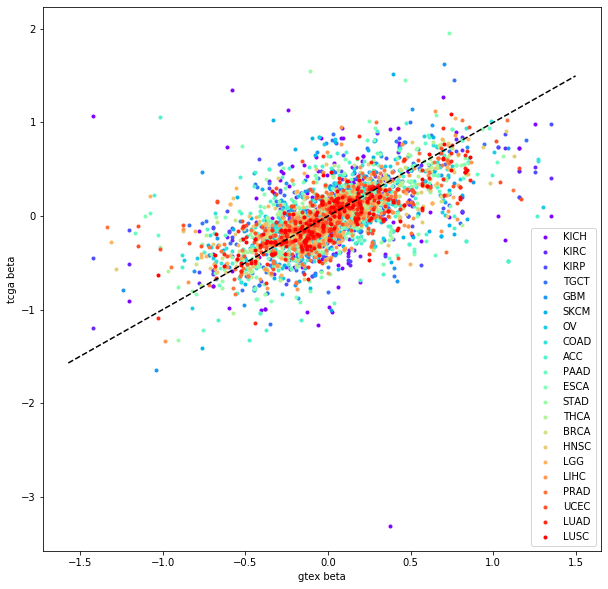

In [83]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

n=compare_beta["file_name"].unique()
color=iter(cm.rainbow(np.linspace(0,1,len(n))))

for x in n:
    c=next(color)
    canc_filt_dev=compare_beta[compare_beta["file_name"]==x]
    plt.scatter(canc_filt_dev["slope"],canc_filt_dev["BETA"],color=c,marker=".",label=x)


ax.set_xlabel("gtex beta")
ax.plot([ax.get_xlim()[0],ax.get_xlim()[1]], [ax.get_xlim()[0],ax.get_xlim()[1]], ls="--", c="k")
ax.set_ylabel("tcga beta")
plt.legend()
fig.savefig('gtex.beta.pdf')

## Get cell types of trans associations

In [120]:
gff3=pd.read_csv("/cellar/users/mpagadal/Data/resources/annotations/gencode.v19.annotation.gff3",delimiter="\t",header=None,comment="#")
gff3.head()

,0,1,2,3,4,5,6,7,8
0,chr1,HAVANA,gene,11869,14412,.,+,.,ID=ENSG00000223972.4;gene_id=ENSG00000223972.4...
1,chr1,HAVANA,transcript,11869,14409,.,+,.,ID=ENST00000456328.2;Parent=ENSG00000223972.4;...
2,chr1,HAVANA,exon,11869,12227,.,+,.,ID=exon:ENST00000456328.2:1;Parent=ENST0000045...
3,chr1,HAVANA,exon,12613,12721,.,+,.,ID=exon:ENST00000456328.2:2;Parent=ENST0000045...
4,chr1,HAVANA,exon,13221,14409,.,+,.,ID=exon:ENST00000456328.2:3;Parent=ENST0000045...


In [121]:
gff3["ID"]=gff3[8].str.split("gene_id=").str[1].str.split(";").str[0]
gff3["type"]=gff3[8].str.split("gene_type=").str[1].str.split(";").str[0]

In [122]:
gff3["ID"]=gff3["ID"].str.split(".").str[0]

In [123]:
mp_type=dict(zip(gff3["ID"],gff3["type"]))

In [124]:
gtex_trans=gtex_assoc[gtex_assoc["assoc"].isin(trans)]

In [127]:
gtex_trans["type"]=gtex_trans["gene_id"].map(mp_type)

/nrnb/opt/anaconda3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [128]:
gtex_trans=gtex_trans[~(gtex_trans["gtex gene"].isnull())]

In [131]:
gtex_trans=gtex_trans[~gtex_trans["gtex gene"].isnull()]

In [132]:
len(gtex_trans["assoc"].unique())

42

In [133]:
df_pie=gtex_trans[["assoc","gene_id","type"]].drop_duplicates()["type"].value_counts()

In [134]:
df_pie=df_pie.reset_index()
df_pie

,index,type
0,protein_coding,142
1,pseudogene,44
2,lincRNA,38
3,processed_transcript,7
4,antisense,7
5,sense_intronic,2
6,sense_overlapping,1


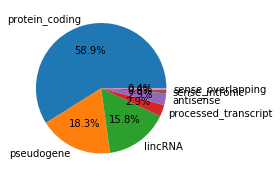

In [135]:
f=plt.figure(figsize=(3,3))
labels = df_pie["index"].tolist()
sizes = df_pie["type"].tolist()
plt.pie(sizes,labels=labels,autopct='%1.1f%%')
f.savefig("./plots/pie.type.pdf")